# From the tutorial series in the Devito repo

# 02 - Reverse Time Migration

This notebook is the second in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this second example we aim to highlight the core ideas behind seismic inversion, where we create an image of the subsurface from field recorded data. This tutorial follows on the modelling tutorial and will reuse the modelling operator and velocity model.

## Imaging requirement

Seismic imaging relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is acquired as described in the first tutorial. In order to simplify this tutorial we will generate synthetic field data by modelling it with the **true velocity model**.

- **Background velocity model**. This is a velocity model that has been obtained by processing and inverting the field data. We will look at this methods in the following tutorial as it relies on the method we are describing here. This velocity model is usually a **smooth version** of the true velocity model.

## Imaging computational setup

In this tutorial, we will introduce the back-propagation operator. This operator simulates the adjoint wave-equation, that is a wave-equation solved in a reversed time order. This time reversal led to the naming of the method we present here, called Reverse Time Migration. The notion of adjoint in exploration geophysics is fundamental as most of the wave-equation based imaging and inversion methods rely on adjoint based optimization methods.

## Notes on the operators

As we already describe the creation of a forward modelling operator, we will use a thin wrapper function instead. This wrapper is provided by a utility class called `AcousticWaveSolver`, which provides all the necessary operators for seismic modeling, imaging and inversion. The `AcousticWaveSolver` provides a more concise API for common wave propagation operators and caches the the Devito `Operator` objects to avoid unnecessary recompilation. However, any newly introduced operators will be fully described and only used from the wrapper in the next tutorials.

As before we initialize printing and import some utilities. We also raise the Devito log level to avoid excessive logging for repeated operator invocations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

#### Make a basic velocity model

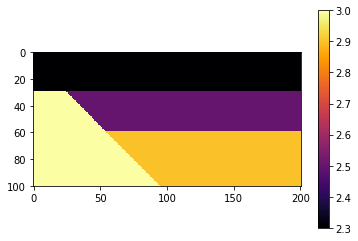

In [2]:
vel_wedge = np.ones((101,201)) * 2
vel_wedge[30:60] = 2.5
vel_wedge[60:] = 2.9
vel_wedge = np.triu(vel_wedge, k=-5)
vel_wedge[:30] = 2.3
vel_wedge[vel_wedge<1] = 3
plt.imshow(vel_wedge, cmap='inferno')
plt.colorbar()

## Computational considerations

Seismic inversion algorithms are generally very computationally demanding and require a large amount of memory to store the forward wavefield. In order to keep this tutorial as light-weight as possible we are using a very simple
velocity model that requires low temporal and special resolution. For a more realistic model, a second set of preset parameters for a reduced version of the 2D Marmousi data set [1] is provided below in comments. This can be run to create some more realistic subsurface images. However, this second present is more computationally demanding and requires a slightly more powerful workstation.

In [4]:
###### Configure model presets
from examples.seismic import demo_model, Model

# Enable model presets here:
# preset = 'twolayer-isotropic'  # A simple but cheap model (recommended)
# preset = 'marmousi2d'  # A larger more realistic model
# preset = 'three-layer-isotropic'
# preset = 'marm_ii'
# preset = 'fourfive_nml_flt_vel'
# preset = 'fourfive_nml_flt_vel_5m'
# preset = 'anticline_faults'
# preset = 'b_anticline_faults'
# preset = 'sixty_nml_flt_vel_5m'
preset = 'vel_wedge'

# Standard preset with a simple two-layer model
if preset == 'twolayer-isotropic':
    def create_model(grid=None):
        return demo_model('twolayer-isotropic', origin=(0., 0.), shape=(101, 101),
                          spacing=(10., 10.), nbpml=100, grid=grid, ratio=2)
    filter_sigma = (1, 1)
    nshots = 1
    nreceivers = 101
    t0 = 0.
    tn = 1000.  # Simulation last 1 second (1000 ms)
    f0 = 0.012  # Source peak frequency is 10Hz (0.010 kHz)
    
# Simple vertical fault model for testing variable fault offset
if preset == 'three-layer-isotropic':
    nbpml=20
    def create_model(grid=None):
        shape = (201, 101)
        v = np.ones(shape, dtype=np.float32)
        v = v * 2.6
#         v[:,20:25] = 3.5
        v[:51, 41:61] = 2.9
        v[51:101, 42:62 ] = 2.9
        v[101:151, 46:66 ] = 2.9
        v[151:, 52:72 ] = 2.9

        return Model(origin=(0., 0.), shape=shape, spacing=(10., 10.), 
                     nbpml=nbpml, vp=v, space_order=2)
    filter_sigma = (1, 1)
    nshots = 41
    nreceivers = 201
    t0 = 0.
    tn = 1300.  # Simulation last 1 second (1000 ms)
    f0 = 0.0150  # Source peak frequency is 10Hz (0.010 kHz)
    
# Resampled portion of the Marmousi-ii 2D model with variable fault offset
if preset == 'marm_ii':
    def create_model(grid=None):
        nbpml = 200
        return Model(origin=(0., 0.), shape=vel_marm_ii.T.shape, spacing=(10., 10.), 
                     nbpml=nbpml, vp=vel_marm_ii.T, space_order=4)
    filter_sigma = (1, 1)
    nshots = 1
    nreceivers = 500
    t0 = 0.
    tn = 800.  # Simulation last 1 second (1000 ms)
    f0 = 0.015  # Source peak frequency is 10Hz (0.010 kHz)

# Variable 45 degree fault model with salt above (10m resolution)
if preset == 'fourfive_nml_flt_vel':
    def create_model(grid=None):
        return Model(origin=(0., 0.), shape=fourfive_nml_flt_vel.T.shape, spacing=(10., 10.), 
                     nbpml=80, vp=fourfive_nml_flt_vel.T, space_order=2)
    filter_sigma = (1, 1)
    nshots = 62
    nreceivers = 250
    t0 = 0.
    tn = 1300.  # Simulation last 1 second (1000 ms)
    f0 = 0.0120  # Source peak frequency is 10Hz (0.010 kHz)
    
# Variable 45 degree fault model with salt above (5m resolution)
if preset == 'fourfive_nml_flt_vel_5m':
    nbpml = 230
    v = np.load('data/45_deg_norm_fault_RTM_5m_IMAGE.npy')
    def create_model(grid=None):
        return Model(origin=(0., 0.), shape=v.T.shape, spacing=(5., 5.), 
                     nbpml=nbpml, vp=fourfive_nml_flt_vel_5m.T, space_order=2)
    filter_sigma = (1, 1)
    nshots = 62
    nreceivers = 500
    t0 = 0.
    tn = 1300.  # Simulation last 1 second (1000 ms)
    f0 = 0.0120  # Source peak frequency is 10Hz (0.010 kHz)

# Variable 60 degree fault model with salt above (5m resolution)
if preset == 'sixty_nml_flt_vel_5m':
    nbpml = 230
    v = np.load('data/63_deg_norm_fault_vp_5m.npy')
    def create_model(grid=None):
        return Model(origin=(0., 0.), shape=v.T.shape, spacing=(5., 5.), 
                     nbpml=nbpml, vp=v.T, space_order=2)
    filter_sigma = (1, 1)
    nshots = 1
    nreceivers = 500
    t0 = 0.
    tn = 800.  # Simulation last 1 second (1000 ms)
    f0 = 0.025  # Source peak frequency is 10Hz (0.010 kHz)
    
# Anticline with vertical faults (5m resolution)
if preset == 'anticline_faults':
    nbpml = 230
    v = np.load('data/anticline_vp_faults_5m.npy')
    def create_model(grid=None):
        return Model(origin=(0., 0.), shape=v.T.shape, spacing=(5., 5.), 
                     nbpml=nbpml, vp=v.T, space_order=2)
    filter_sigma = (1, 1)
    nshots = 62
    nreceivers = 500
    t0 = 0.
    tn = 1300.  # Simulation last 1 second (1000 ms)
    f0 = 0.0120  # Source peak frequency is 10Hz (0.010 kHz)
    
# Broad anticline with 10m vertical faults (5m resolution)
if preset == 'b_anticline_faults':
    nbpml = 300
    v = np.load('data/anticline_broad_vp_faults_5mres_20mflt.npy')
    def create_model(grid=None):
        return Model(origin=(0., 0.), shape=v.T.shape, spacing=(5., 5.), 
                     nbpml=nbpml, vp=v.T, space_order=2)
    filter_sigma = (1, 1)
    nshots = 62
    nreceivers = 500
    t0 = 0.
    tn = 1000.  # Simulation last 1 second (1000 ms)
    f0 = 0.011  # Source peak frequency is 10Hz (0.010 kHz)
    
# A more computationally demanding preset based on the 2D Marmousi model
if preset == 'marmousi2d-isotropic':
    def create_model(grid=None):
        return demo_model('marmousi2d-isotropic', data_path='../../../../opesci-data/',
                          grid=grid)
    filter_sigma = (6, 6)
    nshots = 301  # Need good covergae in shots, one every two grid points
    nreceivers = 601  # One recevier every grid point
    t0 = 0.
    tn = 3500.  # Simulation last 3.5 second (3500 ms)
    f0 = 0.025  # Source peak frequency is 25Hz (0.025 kHz)

# Simple velocity model with some 45 dips
if preset == 'vel_wedge':
    def create_model(grid=None):
        nbpml = 100
        return Model(origin=(0., 0.), shape=vel_wedge.T.shape, spacing=(10., 10.), 
                     nbpml=nbpml, vp=vel_wedge.T, space_order=2)
    filter_sigma = (1, 1)
    nshots = 1
    nreceivers = 500
    t0 = 0.
    tn = 800.  # Simulation last 1 second (1000 ms)
    f0 = 0.020  # Source peak frequency is 10Hz (0.010 kHz)
    

# True and smooth velocity models

First, we create the model data for the "true" model from a given demonstration preset. This model represents the subsurface topology for the purposes of this example and we will later use it to generate our synthetic data readings. We also generate a second model and apply a smoothing filter to it, which represents our initial model for the imaging algorithm. The perturbation between these two models can be thought of as the image we are trying to recover.

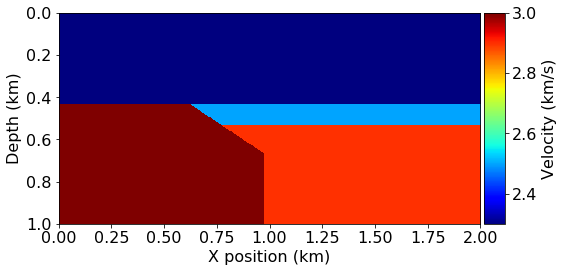

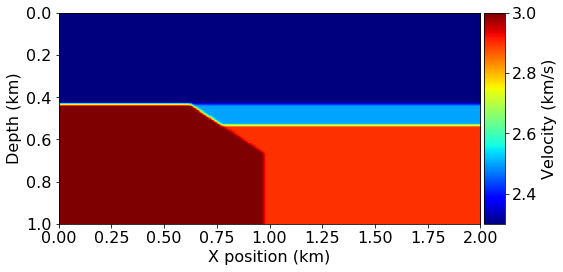

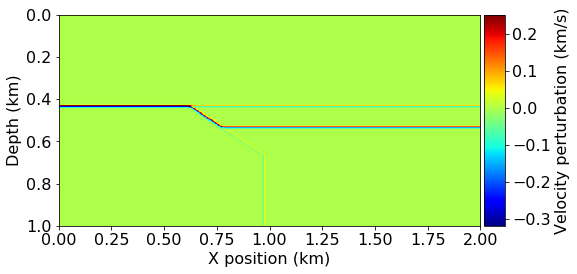

In [5]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_velocity, plot_perturbation
from scipy import ndimage

# Create true model from a preset
model = create_model()

# Create initial model and smooth the boundaries
model0 = create_model(grid=model.grid)
# model0.vp = model0.vp * 0.9
# model0.vp[:,50:60] = 2.5
# rand_vals = np.random.uniform(low=0.95, high=1.05,size=(500,200))
# model0.vp = model0.vp * rand_vals
for i in range(2):
    model0.vp = ndimage.gaussian_filter(model0.vp.data, sigma=filter_sigma, order=0)


# Plot the true and initial model and the perturbation between them
plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

## Acquisition geometry

Next we define the positioning and the wave signal of our source and the location of our receivers. To generate the wavelet for our source we require the discretized values of time that we are going to use to model a single "shot",,
which again depends on the grid spacing used in our model. For consistency this initial setup will look exactly as in the previous modelling tutorial, although we will vary the position of our source later on during the actual imaging algorithm.

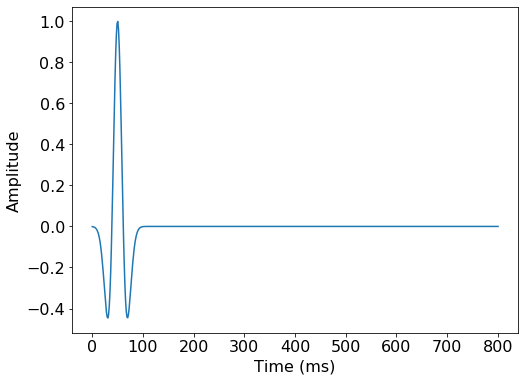

In [6]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 10.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

# True and smooth data

We can now generate the shot record (receiver readings) corresponding to our true and initial models. The difference between these two records will be the basis of the imaging procedure.

For this purpose we will use the same forward modelling operator that was introduced in the previous tutorial, provided by the `WaveSolver` utility class. This object instantiates a set of pre-defined operators according to an initial definition of the acquisition geometry, consisting of source and receiver symbols. The solver objects caches the individual operators and provides a slightly more high-level API that allows us to invoke the modelling modelling operators from the initial tutorial in a single line. In the following cells we use this to generate shot data by only specifying the respective model symbol `m` to use, and the solver will create and return a new `Receiver` object the represents the readings at the previously defined receiver coordinates.  

In [9]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d , _, _ = solver.forward(vp=model.vp, save=True)

In [10]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

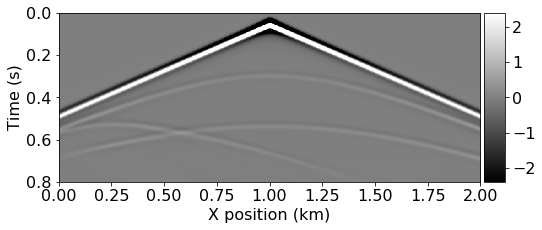

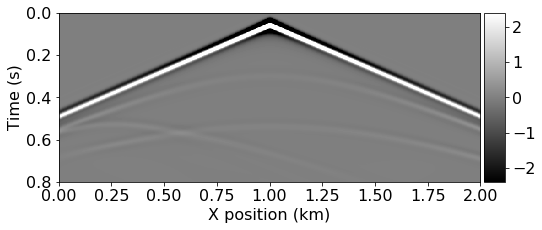

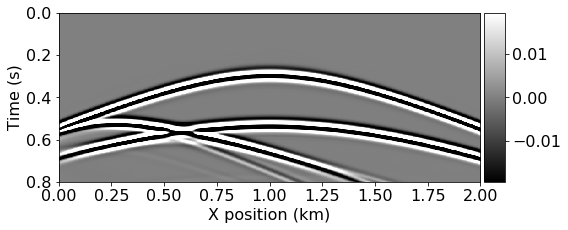

In [11]:
#NBVAL_IGNORE_OUTPUT
# Plot shot record for true and smooth velocity model and the difference
from examples.seismic import plot_shotrecord

plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

# Imaging with back-propagation

As we explained in the introduction of this tutorial, this method is based on back-propagation. 

## Adjoint wave equation

If we go back to the modelling part, we can rewrite the simulation as a linear system solve:

\begin{equation}
\mathbf{A}(\mathbf{m}) \mathbf{u} = \mathbf{q}
\end{equation}

where $\mathbf{m}$ is the discretized square slowness, $\mathbf{q}$ is the discretized source and $\mathbf{A}(\mathbf{m})$ is the discretized wave-equation. The discretized wave-equation matricial representation is a lower triangular matrix that can be solve with forward substitution. The pointwise writing or the forward substitution leads to the time-stepping stencil.

On a small problem one could form the matrix explicitly and transpose it to obtain the adjoint discrete wave-equation:

\begin{equation}
\mathbf{A}(\mathbf{m})^T \mathbf{v} = \delta \mathbf{d}
\end{equation}

where $\mathbf{v}$ is the discrete **adjoint wavefield** and  $\delta \mathbf{d}$ is the data residual defined as the difference between the field/observed data and the synthetic data $\mathbf{d}_s = \mathbf{P}_r \mathbf{u}$. In our case we derive the discrete adjoint wave-equation from the discrete forward wave-equation to get its stencil. 

## Imaging

Wave-equation based imaging relies on one simple concept:

- If the background velocity model is cinematically correct, the forward wavefield $\mathbf{u}$ and the adjoint wavefield $\mathbf{v}$ meet at the reflectors position at zero time offset. 

The sum over time of the zero time-offset correlation of these two fields then creates an image of the subsurface. Mathematically this leads to the simple imaging condition:

\begin{equation}
  \text{Image} = \sum_{t=1}^{n_t} \mathbf{u}[t] \mathbf{v}[t]
\end{equation}

In the following tutorials we will describe a more advanced imaging condition that produces shaper and more accurate results.

## Operator

We will now define the imaging operator that computes the adjoint wavefield $\mathbf{v}$ and correlates it with the forward wavefield $\mathbf{u}$. This operator essentially consist of three components:
* Stencil update of the adjoint wavefield `v`
* Injection of the data residual at the adjoint source (forward receiver) location
* Correlation of `u` and `v` to compute the image contribution at each timestep

In [12]:
# Define gradient operator for imaging
from devito import TimeFunction, Operator, Eq, solve
from examples.seismic import PointSource

def ImagingOperator(model, image):
    # Define the wavefield with the size of the model and the time dimension
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4, save=geometry.nt)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=4,
                     save=geometry.nt)
    
    # Define the wave equation, but with a negated damping term
    eqn = model.m * v.dt2 - v.laplace - model.damp * v.dt

    # Use `solve` to rearrange the equation into a stencil expression
    stencil = Eq(v.backward, solve(eqn, v.backward))
    
    # Define residual injection at the location of the forward receivers
    dt = model.critical_dt
    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)    
    res_term = residual.inject(field=v, expr=residual * dt**2 / model.m)

    # Correlate u and v for the current time step and add it to the image
    image_update = Eq(image, image - u * v)

    return Operator([stencil] + res_term + [image_update],
                    subs=model.spacing_map)

## Implementation of the imaging loop

As we just explained, the forward wave-equation is solved forward in time while the adjoint wave-equation is solved in a reversed time order. Therefore, the correlation of these two fields over time requires to store one of the two fields. The computational procedure for imaging follows:

- Simulate the forward wave-equation with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the image contribution at each time step. 

This procedure is applied to multiple source positions (shots) and summed to obtain the full image of the subsurface. We can first visualize the varying locations of the sources that we will use. 

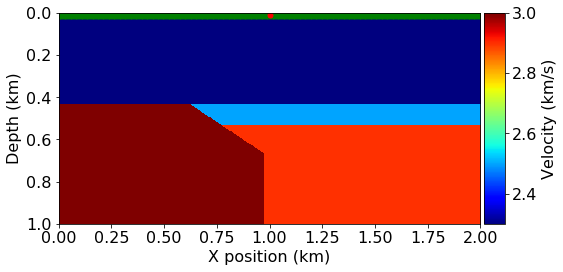

In [13]:
#NBVAL_IGNORE_OUTPUT

# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
# source_locations[:, 0] = np.linspace(0., 2000, num=nshots)
source_locations[:, 0] = 1000 # just place the single source I want to make the animation with in the middle of the model
source_locations[:, 1] = 10.

plot_velocity(model, receiver=rec_coordinates, source=source_locations)

In [14]:
# Run imaging loop over shots
from devito import Function, clear_cache

# Create image symbol and instantiate the previously defined imaging operator
image = Function(name='image', grid=model.grid)
op_imaging = ImagingOperator(model, image)
print(op_imaging)

# Create a wavefield for saving to avoid memory overload
u0 = TimeFunction(name='u', grid=model0.grid, time_order=2, space_order=4,
                  save=geometry.nt)

for i in range(nshots):
    # Important: We force previous wavefields to be destroyed,
    # so that we may reuse the memory.
    clear_cache()
    
    print('Imaging source %d out of %d' % (i+1, nshots))
    
    # Update source location
    geometry.src_positions[0, :] = source_locations[i, :]

    # Generate synthetic data from true model
    true_d, _, _ = solver.forward(vp=model.vp, save=True)
    
    # Compute smooth data and full forward wavefield u0
    u0.data.fill(0.)
    smooth_d, _, _ = solver.forward(vp=model0.vp, save=True, u=u0)
    
    # Compute gradient from the data residual  
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4, save=geometry.nt)
    residual = smooth_d.data - true_d.data
    op_imaging(u=u0, v=v, vp=model0.vp, dt=model0.critical_dt, 
               residual=residual)

#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict damp_vec, const float dt, struct dataobj *restrict image_vec, const float o_x, const float o_y, struct dataobj *restrict residual_vec, struct dataobj *restrict residual_coords_vec, struct dataobj *restrict u_vec, struct dataobj *restrict v_vec, struct dataobj *restrict vp_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int p_residual_M, const int p_residual_m, const int time_M, const int time_m, struct profiler * timers)
{
  float (*restrict damp)[damp_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[damp_vec->size[1]]) damp_vec->data;
  float (*restrict image)[image_vec->

## Plotting it all up

Here we are creating three dimensional array of the images as they build up during the migration. This makes it easier to generate the animation.

In [31]:
#img_book = np.zeros((geometry.nt, model.vp.shape[1], model.vp.shape[0]))
img_book = np.zeros((geometry.nt, model.vp.shape[1]-2*model.nbpml, model.vp.shape[0]-2*model.nbpml))
for i in range(geometry.nt):
    v_dat = v.data[i,model.nbpml:-model.nbpml,model.nbpml:-model.nbpml].T
    u0_dat = u0.data[i,model.nbpml:-model.nbpml,model.nbpml:-model.nbpml].T
    img_book[i] = v_dat * u0_dat
img_book = np.flip(img_book, axis=0)

##### Quick check that the final image looks reasonable

(201, 101)
(201, 101)


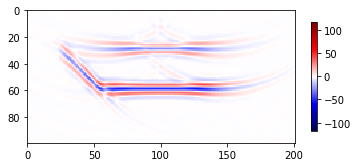

In [42]:
#shape = model.vp.shape
shape= (model.vp.shape[0]-2*model.nbpml, model.vp.shape[1]-2*model.nbpml)
amp_correction = np.empty(shape)
print(amp_correction.shape)
amp_correction[:] = np.arange(shape[1])
pwr_corr = 1.3
corrected = ((np.diff(np.sum(img_book[:800], axis=0), axis=0)).T * (amp_correction[:,:-1]**pwr_corr)).T / np.max(np.diff(np.sum(img_book, axis=0), axis=0))
print(amp_correction.shape)

plt.imshow(corrected,cmap='seismic', vmin=-img_book.max() * 0.2, vmax=img_book.max() * 0.2)
plt.colorbar(shrink=0.5)

##### Generate an animation of the adjoint wavefield solution from the "true" data and the forward wavefield, along with the progressively updated resulting image. This can take a little while depending on your computer.

7.193200825881959
()
72.38037045593262
(573, 101, 201)
(201, 101)


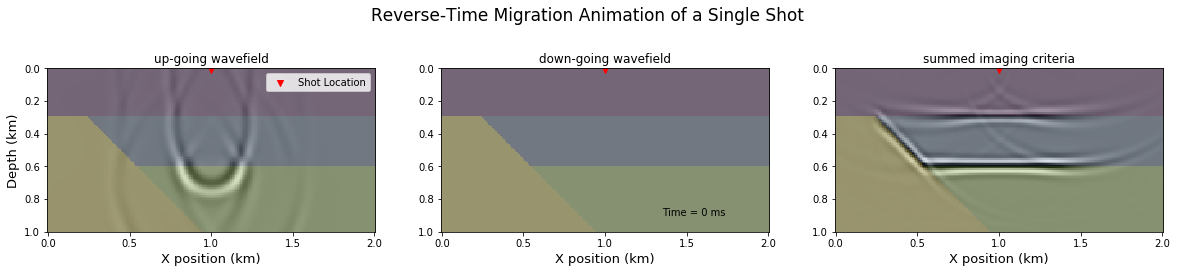

In [47]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
cmap = 'gray'
titles = ['up-going wavefield', 'down-going wavefield', 'summed imaging criteria']
fig.suptitle('Reverse-Time Migration Animation of a Single Shot', y=0.9, size=17)

# get the value limits for plotting
p = 99.995
lim_u0 = np.percentile(u0.data,p)
print(lim_u0)
print(lim_u0.shape)
lim_v = np.percentile(v.data,p)
print(lim_v)
print(img_book.shape)
print(amp_correction.shape)
lim_image = np.percentile(((np.diff(np.sum(img_book, axis=0), axis=0)).T * 
                           (amp_correction[:,:-1]**pwr_corr)).T / np.max(np.diff(np.sum(img_book, axis=0), axis=0)),p)

#shape = model.vp.shape
shape= (model.vp.shape[0]-2*model.nbpml, model.vp.shape[1]-2*model.nbpml)
amp_correction = np.empty(shape)
amp_correction[:] = np.arange(shape[1])
pwr_corr = 1.3

im = ax[0].imshow(v.data[0,model.nbpml:-model.nbpml,model.nbpml:-model.nbpml].T, 
                  vmin=-lim_v, vmax=lim_v, cmap=cmap, animated=True)
im2 = ax[1].imshow(u0.data[0,model.nbpml:-model.nbpml,model.nbpml:-model.nbpml].T, 
                   vmin=-lim_u0, vmax=lim_u0, cmap=cmap, animated=True)
im3 = ax[2].imshow(img_book[0], vmin=-lim_image, vmax=lim_image, cmap=cmap, animated=True)
annotation = ax[1].annotate(f'Time = {tn - int(np.floor(0 * model.critical_dt))} ms', (135,90), animated=True)

for i,a in enumerate(ax):
    a.imshow(vel_wedge, alpha=0.2)
    a.set_title(titles[i])
    a.scatter(int(np.floor(source_locations[0,0] / model.spacing[0])), 
              int(np.floor(source_locations[0,1] / model.spacing[0])), color='r', marker='v', label='Shot Location')

ax[0].legend()

# label the axes to correspond to the proper distances and depths. I haven't made this flexible yet.
for axes in ax:
    axes.set_yticks(np.array([0,20,40,60,80,100]))
    axes.set_yticklabels(np.array([0,0.2, 0.4, 0.6,0.8,1.0]))
    axes.set_xticks(np.array([0,50,100,150,200]))
    axes.set_xticklabels(np.array([0,0.5, 1.0, 1.5, 2.0]))
    axes.set_xlabel('X position (km)', size=13)
ax[0].set_ylabel('Depth (km)', size=13)
ax[0].set_ylabel('Depth (km)', size=13)

def updatefig(i, img):
    v_dat = v.data[-i,model.nbpml:-model.nbpml,model.nbpml:-model.nbpml].T
    u0_dat = u0.data[-i,model.nbpml:-model.nbpml,model.nbpml:-model.nbpml].T
    im.set_data(v_dat)
    im2.set_data(u0_dat)
    
    corrected = ((np.diff(np.sum(img_book[:i], axis=0), axis=0)).T * 
                 (amp_correction[:,:-1]**pwr_corr)).T / np.max(np.diff(np.sum(img_book, axis=0), axis=0))
    im3.set_data(corrected)
    annotation.set_text(f'Time = {int(tn - (np.floor(i * model.critical_dt)))} ms')
    return im, im2, annotation

ani = animation.FuncAnimation(fig, updatefig, frames=np.linspace(1, geometry.nt -1, geometry.nt -1, dtype=np.int64), 
                              blit=True, interval=40, fargs=(img_book,))

HTML(ani.to_html5_video())

#### Just for fun, a seperate animation of the shot record and the adjoint solution together

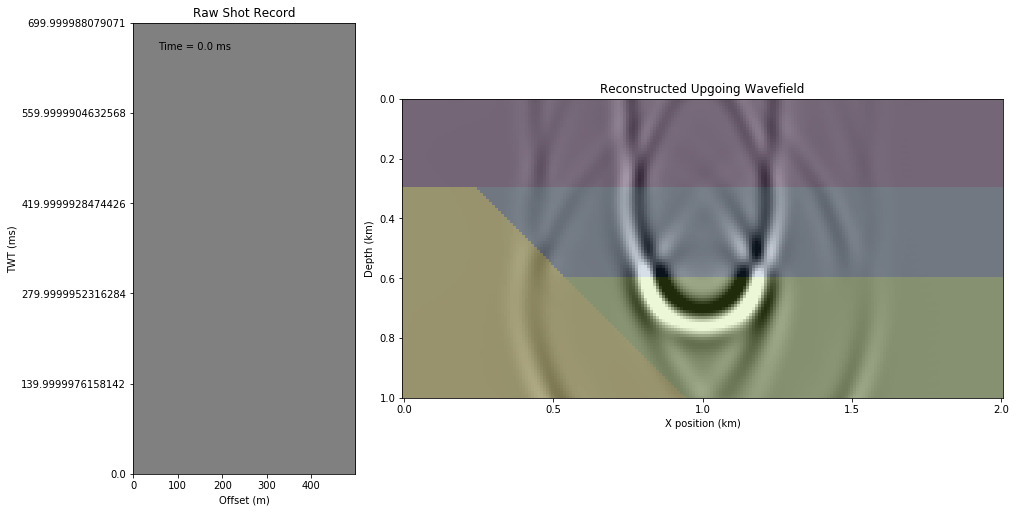

In [49]:
from matplotlib.gridspec import GridSpec

p = 99.8
titles = ['Raw Shot Record', 'Reconstructed Upgoing Wavefield']
fig = plt.figure(constrained_layout=True, figsize=(14,7))
offsets = abs(rec_coordinates - src_coordinates)

gs = GridSpec(nrows=1, ncols=5, figure=fig)
ax0 = fig.add_subplot(gs[0,:2])
ax1 = fig.add_subplot(gs[0,2:])
axes = (ax0, ax1)
n=200
shot = np.array(true_d.data) * np.arange(true_d.data.shape[0]).reshape(true_d.data.shape[0], 1)
shot_lim = np.percentile(shot,p)
shot = np.flip(shot, axis=0)
shot[:n] = 0
v_dat = v.data[-n,model.nbpml:-model.nbpml,model.nbpml:-model.nbpml].T
v_lim = np.percentile(v.data,p)

im0 = ax0.imshow(shot, aspect='auto', cmap='gray', vmin=-shot_lim, vmax=shot_lim)
im1 = ax1.imshow(v_dat, vmin=-v_lim, vmax=v_lim, aspect='equal', cmap='gray')
line = ax0.axhline(0, animated=True, lw=2, color='r')
annotation = ax0.annotate(f'Time = {tn - int(np.floor(0 * model.critical_dt))} ms', (55,30))
ax1.imshow(vel_wedge, aspect='equal', alpha=0.2)
ax1.set_ylim(0,99)
ax1.invert_yaxis()
ax0.set_ylabel('TWT (ms)')
ax0.set_xlabel('Offset (m)')
ax1.set_ylabel('Depth (km)')
ax1.set_xlabel('X position (km)')

for i,a in enumerate(axes):
    a.set_title(titles[i])

ax0.set_yticks(np.array([0,100,200,300,400,500]))
ax0.set_yticklabels(np.array(np.flip([0,100,200,300,400,500], axis=0)) * model.critical_dt)    
ax1.set_yticks(np.array([0,20,40,60,80,100]))
ax1.set_yticklabels(np.array([0,0.2, 0.4, 0.6,0.8,1.0]))
ax1.set_xticks(np.array([0,50,100,150,200]))
ax1.set_xticklabels(np.array([0,0.5, 1.0, 1.5,2.0,]))

def update_anim(i):
    v_dat = v.data[-i,model.nbpml:-model.nbpml,model.nbpml:-model.nbpml].T
    shot = np.array(true_d.data) * np.arange(true_d.data.shape[0]).reshape(true_d.data.shape[0], 1)
    shot = np.flip(shot, axis=0)
    shot[:i] = 0 
    im0.set_data(shot)
    im1.set_data(v_dat)
    line.set_ydata(abs(i))
    annotation.set_text(f'Time = {tn - int(np.floor(i * model.critical_dt))} ms')
    return im0, im1, line

ani = animation.FuncAnimation(fig, update_anim, frames=np.linspace(1, geometry.nt -1, geometry.nt -1, dtype=np.int64),
                             blit=True, interval=40)

HTML(ani.to_html5_video())

In [ ]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_image

# Plot the inverted image
plot_image(np.diff(image.data, axis=1))

In [ ]:
model.spacing

## Scratch area plotting

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

shape = model.vp.shape
amp_correction = np.empty(shape)
amp_correction[:] = np.arange(shape[1])
pwr_corr = 1.3
j=1
nbpml = model.nbpml
corrected = ((np.diff(image.data[nbpml:-nbpml,nbpml:-nbpml+1], axis=1) * (amp_correction**pwr_corr)).T) / np.max(image.data)
lim = np.percentile(corrected, 99.9)

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
ax0.scatter(source_locations[:,0] // model.spacing[0], source_locations[:,1] // model.spacing[0], color='r', label='Shot locations', s=10)
im1=ax0.imshow(model.vp.T, cmap='viridis', aspect='equal')#, extent=extent)
im2=ax1.imshow(corrected, cmap='gray', vmin=-lim, vmax=lim, aspect='equal')
cbar0 = plt.colorbar(im1, shrink=0.8, ax=ax0)
cbar1 = plt.colorbar(im2, shrink=0.8, ax=ax1)
cbar0.set_label('Vp (km/s)')
cbar1.set_label('Amplitude')

ax0.legend(loc=3)
ax0.set_title('Velocity model and shot locations (VE=None)', size=15)
ax1.set_title('RTM image', size=15)
for axes in (ax0, ax1):
    axes.set_yticks(j * np.array([0,20,40,60,80,100]))
    axes.set_yticklabels(np.array([0,0.2, 0.4, 0.6,0.8,1.0]))
    axes.set_xticks(j * np.array([0,50,100,150,200]))
    axes.set_xticklabels(np.array([0,0.5, 1.0, 1.5, 2.0]))
    axes.set_xlabel('X position (km)', size=13)
ax0.set_ylabel('Depth (km)', size=13)
ax1.set_ylabel('Depth (km)', size=13)


# offsets = [10, 20, 30, 40]
# x_loc = np.array([505, 1005, 1505, 2005]) // 5
# y_loc = np.array([495, 505, 515, 525]) // 5
# buff = 30

# for o,x,y in zip(offsets, x_loc, y_loc):
#     ax0.annotate(f'{o} m offset', xy=(x, y), xytext=(x - buff, y - buff),
#                  arrowprops=dict(facecolor='white', shrink=0.05), color='black',
#                  ha='center'
#                 )

# plt.savefig('figures/60_deg_normal_faults_lrgr_RTM_5m_50Hz_2GaussVp.png', dpi=250,bbox_inches='tight')
# plt.savefig('figures/anticline_faults_RTM_5m.png', dpi=250,bbox_inches='tight')
# plt.savefig('figures/b_anticline_faults_11`Hz_RTM_5m_20mflts.png', dpi=250,bbox_inches='tight')
# plt.savefig('figures/marm_ii_32_Hz_RTM_10m.png', dpi=250,bbox_inches='tight')

In [ ]:
model.nbpml

### We might want to save the image and model. The line below will save the image, model, and some information about the setup in a single file so we can retrieve it later.

In [ ]:
np.savez('data/b_anticline_faults_11Hz_RTM_5m_20mflts_IMAGE.npz', 
         params=np.array(['5m res', '11 Hz Ricker','2 Gauss Filt']), 
         fault_offsets=np.array([20]), 
         image=corrected, 
         vp_model=model.vp,
        )

## Plotting for saved data

In [ ]:
data = np.load('data/b_.npz')

In [ ]:
print(data['params'])
print('Offsets: ' + str(data['fault_offsets']) + ' m')

In [ ]:
vp_model = data['vp_model']
j=2
corrected = data['image']
lim = np.percentile(corrected, 99.9)

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
ax0.scatter(source_locations[:,0] // 5, source_locations[:,1] // 5, color='r', label='Shot locations', s=10)
im1=ax0.imshow(vp_model.T, cmap='Pastel1', aspect='equal')#, extent=extent)
im2=ax1.imshow(corrected, cmap='gray', vmin=-lim, vmax=lim, aspect='equal')
cbar0 = plt.colorbar(im1, shrink=0.8, ax=ax0)
cbar1 = plt.colorbar(im2, shrink=0.8, ax=ax1)
cbar0.set_label('Vp (km/s)')
cbar1.set_label('Amplitude')

ax0.legend(loc=3)
ax0.set_title('Velocity model and shot locations (VE=None)', size=15)
ax1.set_title('RTM image', size=15)
for axes in (ax0, ax1):
    axes.set_yticks(j * np.array([0,20,40,60,80,100]))
    axes.set_yticklabels(np.array([0,0.2, 0.4, 0.6,0.8,1.0]))
    axes.set_xticks(j * np.array([0,50,100,150,200,250]))
    axes.set_xticklabels(np.array([0,0.5, 1.0, 1.5, 2.0 , 2.5]))
    axes.set_xlabel('X position (km)', size=13)
ax0.set_ylabel('Depth (km)', size=13)
ax1.set_ylabel('Depth (km)', size=13)


offsets = data['fault_offsets']
x_loc = np.array([505, 1005, 1505, 2005]) // 5
y_loc = np.array([495, 505, 515, 525]) // 5
buff = 30

for o,x,y in zip(offsets, x_loc, y_loc):
    ax0.annotate(f'{o} m offset', xy=(x, y), xytext=(x - buff, y - buff),
                 arrowprops=dict(facecolor='white', shrink=0.05), color='black',
                 ha='center'
                )

# plt.savefig('figures/60_deg_normal_faults_RTM_5m_11Hz_rndmMultiVp.png', dpi=250,bbox_inches='tight')
    

In [ ]:
check = np.load('data/63_deg_norm_fault_vp_5m_IMAGE.npy')
plt.imshow(check, cmap='RdYlGn')
plt.colorbar(shrink=0.5)

In [ ]:
gain=3
norm = corrected.T / np.max(corrected)
step=4

plt.figure(figsize=(20,10))
for i in range(len(norm)):
    if i*step < shape[0]:
        plt.plot(norm[i * step] * gain + i * step, range(shape[1]), c='k')
        plt.fill_betweenx(range(shape[1]), i * step, norm[i * step] * gain + i * step,
                          where=norm[i * step] * gain + i > i, interpolate=True, color='k')
        plt.fill_betweenx(range(shape[1]), i * step, norm[i * step] * gain + i * step,
                          where=norm[i * step] * gain + i < i, interpolate=True, color='r')
    else:
        break

plt.xlim(-1,shape[0])
plt.ylim(0,shape[1])
plt.gca().invert_yaxis()

In [ ]:
assert np.isclose(np.linalg.norm(image.data), 1e6, rtol=1e1)

And we have an image of the subsurface with a strong reflector at the original location.

## References

[1] _Versteeg, R.J. & Grau, G. (eds.) (1991): The Marmousi experience. Proc. EAGE workshop on Practical Aspects of Seismic Data Inversion (Copenhagen, 1990), Eur. Assoc. Explor. Geophysicists, Zeist._

In [ ]:
import segyio
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# with segyio.open(r"data/vp_marmousi-ii.segy", ignore_geometry=True) as f:
with segyio.open(r"data/vel_z6.25m_x12.5m_exact.segy", ignore_geometry=True) as f:
# with segyio.open(r"data/vp_marmousi-ii.segy", ignore_geometry=True) as f:

    vel = np.zeros([len(f.trace),len(f.trace[0])])
    
    for i in range(len(vel)):
        vel[i] = f.trace[i]

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(vel.T)
plt.colorbar(shrink=0.5)

In [ ]:
# plt.imshow(vel[800:1600,550:].T)
vel_marm_ii = resize(vel[800:1600,550:].T, (101,201), mode='reflect', anti_aliasing=True)
plt.imshow(vel_marm_ii, cmap='viridis')
plt.colorbar(shrink=1)

In [ ]:
# plt.imshow(vel[2500:2500+1911,:].T)
vel_marm_ii = resize(vel[2500:2500+1911,:].T, (101,101), mode='reflect', anti_aliasing=True) / 1e3
plt.imshow(vel_marm_ii, cmap='viridis')
plt.colorbar(shrink=1)
# vel[2500:2500+1911,:].T.shape

In [ ]:
plt.imshow(vel[6000:10000,:].T)
plt.colorbar(shrink=0.5)

In [ ]:
plt.imshow(vel[9000:10000,1500:2000].T)
plt.colorbar(shrink=0.5)

In [ ]:
vel_marm_ii = resize(vel[9000:10000,1500:2000].T, (101,201), mode='wrap', anti_aliasing=True)
plt.imshow(vel_marm_ii, cmap='viridis')
plt.colorbar(shrink=1)

In [ ]:
vel_marm_ii = resize(vel[8400:8800,1000:1200].T, (101,201), mode='wrap', anti_aliasing=True)
plt.imshow(vel_marm_ii, cmap='viridis')
plt.colorbar(shrink=1)

In [ ]:
vel_wedge = np.ones((101,201)) * 2
vel_wedge[30:60] = 2.5
vel_wedge[60:] = 2.9
vel_wedge = np.triu(vel_wedge, k=-5)
vel_wedge[:30] = 2.3
vel_wedge[vel_wedge<1] = 3
plt.imshow(vel_wedge, cmap='inferno')
plt.colorbar()